Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from statsmodels.formula.api import ols
import statsmodels.api as sm

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from custom_functions import * #remove_extremes

Import dataset that was cleaned and prepared in Data Preparation notebook

In [2]:
conn = sqlite3.connect('../../data/processed/main.db')
query = '''SELECT * FROM df_main'''
df_main = pd.read_sql(query, conn, index_col='index').reset_index(drop=True)
#df_main.drop('index', axis=1, inplace=True)
df_main.head(3)
y = 'SalePrice'

In [3]:
def remove_df_extremes(df, devct, drop_zeros=False):
    
    for col in df.columns:
        df[col] = [float(num) for num in df[col]]
        med = df[col].median()
        std = df[col].std()

        max_ = med + devct*std
        min_ = 0.0000001 if drop_zeros else med - devct*std 

        df[col] = [x if ((x>min_) & (x<max_)) else np.nan for x in df[col]]
    df.dropna(inplace=True)
    return df

In [84]:
def produce_model(df, x, y, devct, drop_zeros=False):
    model_data = pd.concat([df[y], df[x]], axis=1)
    model_data_trimmed = remove_df_extremes(model_data, devct, drop_zeros)

    formula = y + ' ~ ' + '+'.join(xs)
    
    #formula_TESTING = 'SalePrice ~ SqFtTotLiving+Bedrooms+YrBuilt+Condition+Stories'
    model = ols(formula, model_data_trimmed).fit()
    print(formula)
    
    return model, model_data_trimmed

In [85]:
def qq(df, col):
    plt.figure(figsize=(12,6));
    sm.graphics.qqplot(df[col], line='45', fit=True)
    plt.title(f'Normality Assumption Check: QQ plot of {col} values');

In [86]:
def dist(df, x):
    plt.figure(figsize=(12,6));
    sns.distplot(df[x])
    plt.title(f'Distribution of {x} (KDE)')

In [87]:
def scatter(df, x, model):
    plt.figure(figsize=(12, 6));
    sns.lmplot(data = df, x=x, y=y, line_kws={'color':'r'})    
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'Linearity Assumption: {x} vs. {y}');

SalePrice ~ SqFtTotLiving+BldgGrade+SqFt1stFloor+SqFt2ndFloor+BathFullCount+SqFtFinBasement+SqFtOpenPorch+Bedrooms+SqFtTotBasement+Stories+FinBasementGrade+Bath3qtrCount+BathHalfCount+SqFtDeck+FpMultiStory+SqFtGarageAttached+FpSingleStory+HeatSystem+FpAdditional+YrRenovated


C:\Users\seths\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1830: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\seths\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\seths\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<Figure size 864x432 with 0 Axes>

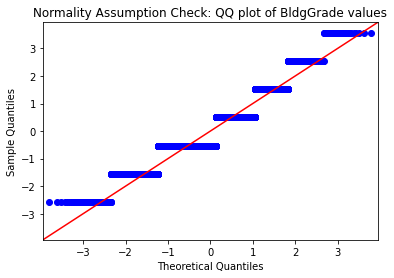

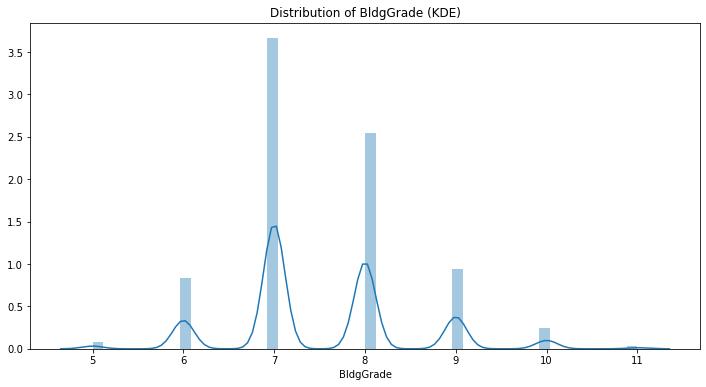

<Figure size 864x432 with 0 Axes>

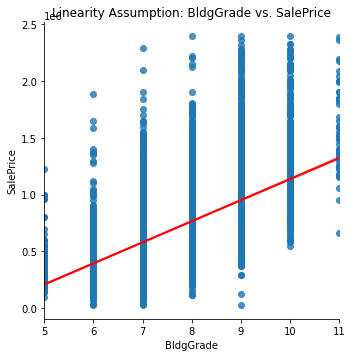

In [99]:
xs = ['SqFtTotLiving', 'Bedrooms', 'YrBuilt', 'Condition', 'Stories', 'forced_air_heating_bin', 'BldgGrade']


xs = ['SqFtTotLiving',
 'BldgGrade',
 'SqFt1stFloor',
 'SqFt2ndFloor',
 'BathFullCount',
 'SqFtFinBasement',
 'SqFtOpenPorch',
 'Bedrooms',
 'SqFtTotBasement',
 'Stories',
 'FinBasementGrade',
 'Bath3qtrCount',
 'BathHalfCount',
 'SqFtDeck',
 'FpMultiStory',
 'SqFtGarageAttached',
 'FpSingleStory',
 'HeatSystem',
 'FpAdditional',
 'YrRenovated']



model, df_trimmed = produce_model(df_main, xs, y, 3)
model.summary()

# fig = plt.figure(figsize=(15,8))
# fig = sm.graphics.plot_regress_exog(model, 'YrBuilt', fig=fig)
# plt.show()


x = 'BldgGrade'
qq(df_trimmed, x);
dist(df_trimmed, x)
scatter(df_trimmed, x, model)

In [94]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     2792.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:18:06   Log-Likelihood:            -2.4059e+05
No. Observations:               17368   AIC:                         4.812e+05
Df Residuals:                   17360   BIC:                         4.812e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               6.897e+06   1.55e+05     44.428      0.000    6.59e+06     7.2e+06
SqFtTotLiving            173.4736      4.068     42.642      0.000     165.500     181.448
Bedrooms                -3.57e+04   2994.819    -11.922      0.000   -4.16e+04   -2.98e+04
YrBuilt                -3964.7981     80.642    -49.165      0.000   -4122.865   -3806.731
Condition               1.213e+04   2991.257      4.054      0.000    6262.607     1.8e+04
Stories                 5.895e+04   4582.154     12.865      0.000       5e+04    6.79e+04
forced_air_heating_bin -5.473e+04   4729.470    -11.571      0.000    -6.4e+04   -4.55e+04
BldgGrade               1.755e+05   2856.004     61.451      0.000     1.7e+05    1.81e+05
==============================================================================
Omnibus:                     3326.514   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10720.094
Skew:                           0.974   Prob(JB):                         0.00
Kurtosis:                       6.319   Cond. No.                     2.37e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

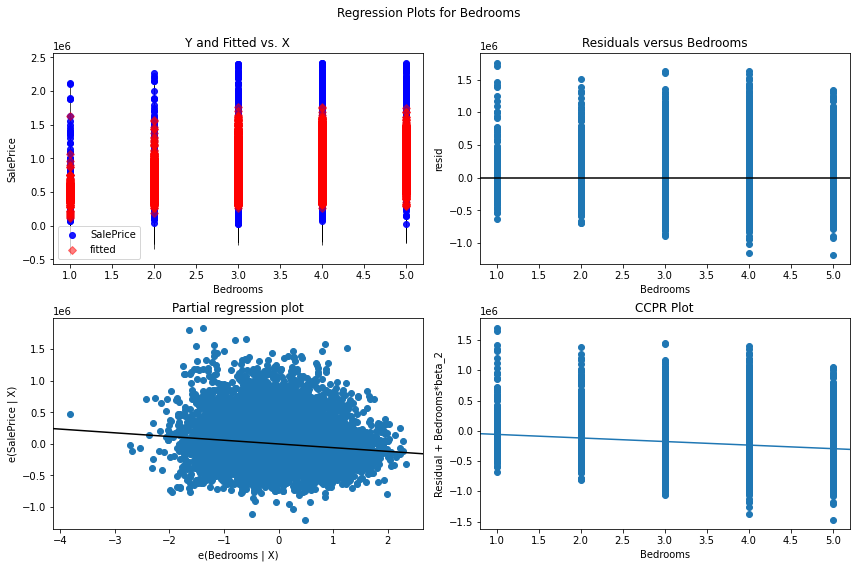

In [20]:
sm.graphics.plot_regress_exog(model, 'Bedrooms', fig=plt.figure(figsize=(12, 8)));

In [21]:
df_main.columns

Index(['SalePrice', 'Parcel_ID', 'NbrLivingUnits', 'Stories', 'BldgGrade',
       'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor',
       'SqFtUnfinFull', 'SqFtUnfinHalf', 'SqFtTotLiving', 'SqFtTotBasement',
       'SqFtFinBasement', 'FinBasementGrade', 'SqFtGarageBasement',
       'SqFtGarageAttached', 'DaylightBasement', 'SqFtOpenPorch',
       'SqFtEnclosedPorch', 'SqFtDeck', 'HeatSystem', 'HeatSource',
       'BrickStone', 'ViewUtilization', 'Bedrooms', 'BathHalfCount',
       'Bath3qtrCount', 'BathFullCount', 'FpSingleStory', 'FpMultiStory',
       'FpFreestanding', 'FpAdditional', 'YrBuilt', 'YrRenovated', 'Condition',
       'SaleInstrument', 'SaleWarning', 'forced_air_heating',
       'forced_air_heating_bin'],
      dtype='object')

Text(0.5, 1.0, 'Correlation Matrix for Remaining Features')

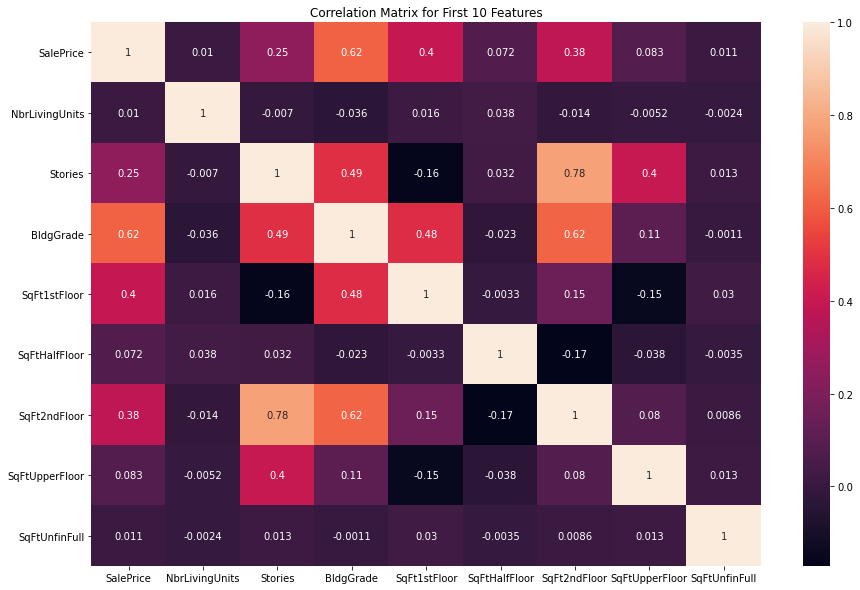

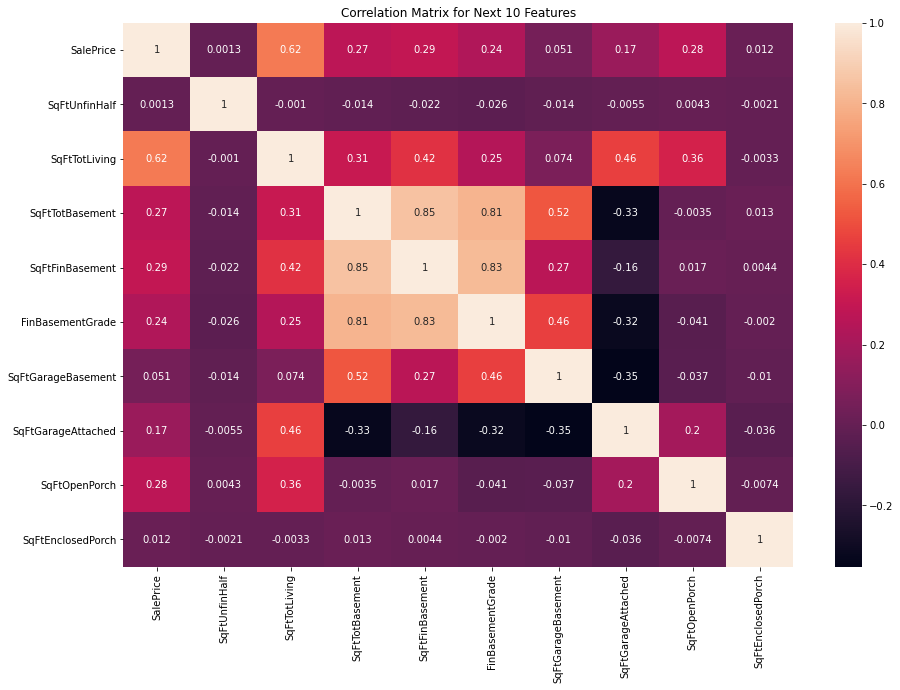

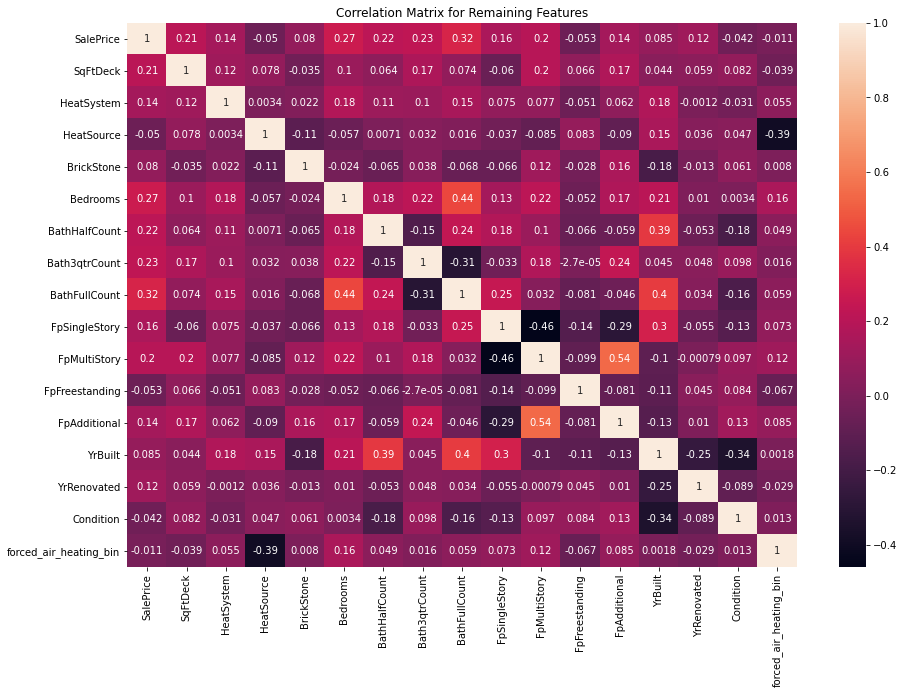

In [75]:
#all_data = pd.concat([df_main[y], df_main[xs]], axis=1)
CorrMatrix = all_data.corr()


CorrMatrix = df_main.iloc[:, :10].corr()
plt.figure(figsize=(15,10))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Correlation Matrix for First 10 Features');

CorrMatrix = pd.concat([df_main[y], df_main.iloc[:, 10:20]], axis=1).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Correlation Matrix for Next 10 Features')

CorrMatrix = pd.concat([df_main[y], df_main.iloc[:, 20:]], axis=1).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Correlation Matrix for Remaining Features')

In [101]:
correlations = df_main.corr().stack().reset_index()
correlations = correlations.loc[(correlations.level_0 == 'SalePrice') & (correlations.level_1 != 'SalePrice')]
correlations[0] = correlations[0].abs()
correlations.columns = ['Dependent', 'Feature', 'Correlation (abs)']

correlations.sort_values(by='Correlation (abs)', ascending=False, inplace=True)
correlations.reset_index(inplace=True, drop=True)
listed = list(correlations.loc[correlations['Correlation (abs)'] > 0.1].Feature.values)

df_main[listed].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18143 entries, 0 to 18142
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SqFtTotLiving       18143 non-null  int64  
 1   BldgGrade           18143 non-null  int64  
 2   SqFt1stFloor        18143 non-null  int64  
 3   SqFt2ndFloor        18143 non-null  int64  
 4   BathFullCount       18143 non-null  int64  
 5   SqFtFinBasement     18143 non-null  int64  
 6   SqFtOpenPorch       18143 non-null  int64  
 7   Bedrooms            18143 non-null  int64  
 8   SqFtTotBasement     18143 non-null  int64  
 9   Stories             18143 non-null  float64
 10  FinBasementGrade    18143 non-null  int64  
 11  Bath3qtrCount       18143 non-null  int64  
 12  BathHalfCount       18143 non-null  int64  
 13  SqFtDeck            18143 non-null  int64  
 14  FpMultiStory        18143 non-null  int64  
 15  SqFtGarageAttached  18143 non-null  int64  
 16  FpSi